# Object detection using a YOLO V4 custom model training

*by Georgios K. Ouzounis*

In this exercise, we will experiment with object detection in still images using the YOLO V4 model customized for our data. The challenge will be to perform face mask detection after training a new model with images from a publicly available dataset in www.kaggle.com 

Before starting, please go to *Runtime->Change runtime type* and chose GPU as your hardware accelerator. This code will work only under this assumption.

In [ ]:
# import the relevant libraries
import numpy as np
import cv2 # openCV

In [ ]:
#install requirements.txt file
!pip install -r requirements.txt

## Configure the DarkNet project

clone the darknet project

In [ ]:
#Clone the github repo of darknet project 

!git clone https://github.com/AlexeyAB/darknet.git

In [ ]:
#Once succesfull cloning is done, you should be able to see a folder named 'darknet' where the project has been downloaded
#Move to the 'darknet' directory
%cd darknet

/content/darknet


###  1st: change settings in the Makefile to enable GPU processing, CUDA, and OpenCV

In [ ]:
#Using the below line of python command, you are changing configuration in Makefile to enable GPU processing

!sed -i 's/GPU=0/GPU=1/g' Makefile

In [ ]:
#Using the below line of python command, you are changing configuration in Makefile to enable CUDA

!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile

In [ ]:
#Using the below line of python command, you are changing configuration in Makefile to enable OpenCV

!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile

confirm changes

In [ ]:
#To make sure all the changes has been done properly, you can have a look at the Makefile

!head Makefile

Click on the darknet folder on the left side of workspace and double click the Makefile to open it on the right of this window.

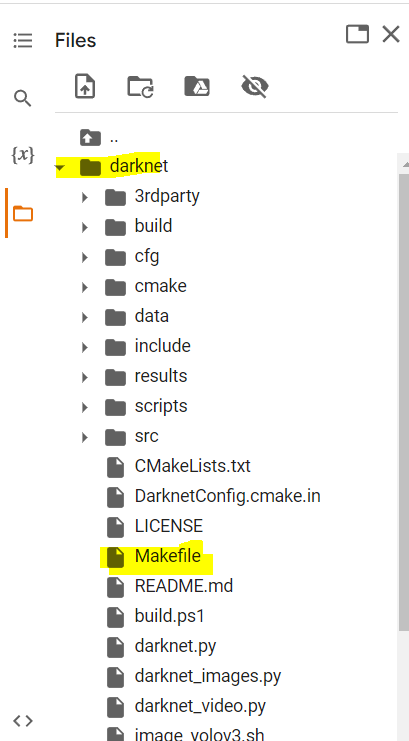

Scroll down to line 20: ARCH = ...
and delete the two lines:

**-gencode arch=compute_35,code=sm_35 \**

**-gencode arch=compute_50,code=[sm_50,compute_50] \**

as CUDA no longer supports  these GPU architectures.

The new text block should be as follows:

**ARCH= -gencode arch=compute_52,code=[sm_52,compute_52] \
        -gencode arch=compute_61,code=[sm_61,compute_61]**


create a ```model``` directory in your Google Drive and store all critical files there


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#In the below line of code, you are creating a directory called 'custom_object' in your drive where you will be storing all critical files
%mkdir ../drive/MyDrive/custom_object/
#In the below line of code, you are copying the Makefile in the newly created drive folder (custom_object)
%cp Makefile ../drive/MyDrive/custom_object/

mkdir: cannot create directory ‘../drive/MyDrive/custom_object/’: File exists


### 2nd: Get pretrained weights for new training and testing 

In [ ]:
#To keep the project organised, its important to have segregate folders
#Let's have a seperate folder called 'customization' where you will be storing pretrained weights for training and testing
%mkdir customization
#Move to 'customization' directory
%cd customization

/content/darknet/customization


In [ ]:
#get the pre-trained weights from darknet project on github repo

!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [ ]:
#For backup purpose, store the weights file in the backup file you created on google drive

%cp yolov4.weights ../../drive/MyDrive/custom_object/

### 3d: create a new custom network configuration file 

make a new copy of the original configuration file

In [ ]:
#We are creating a custom model specific to our use case so you will need to do few changes in the configuration file as well
#Instead of doing direct changes in the cloned configuration file, let's create a copy of the yolov4.cfg file
%cp ../cfg/yolov4.cfg .

 Double click on yolov4.cfg in darknet -> customization directory to open it on the left in this window for editing. See [instructions](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects) for more details.
- change the following:
  1. line 3: a subdivision is the number of tiles each image is cut to for GPU processing. Change this from: **subdivisions=8 -> subdivisions=64**
  2. line 7: the resized image’s width. Change this from **width=608 -> width=416**
  3. line 8: the resized image’s height. Change  this from **height=608 -> height=416**
  4. line 19: max_batches is equal to classes\*2000 but not less than the number of training images and not less than 6000. Change this from **max_batches = 500500 -> 4000** for our two classes.
  5. line 21: change line steps to 80% and 90% of max_batches. We use a single step for memory efficiency. Change this from **steps=400000,450000 -> steps=3200**
- change the last set of filters before each output layer:
  1. line 961, 1049, 1137: change from **filters=255 -> filters=21**. The rule is (classes + 5)x3 in the 3 [convolutional] before each [yolo] layer. Keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers.
- change the number of classes in each output layer:
  1. line 968, 1056, 1144: change from **classes=80 ->classes=2**.
 
- Press Ctrl+S to save the edited cfg file.

**REMARK**
 
The **max_batches** entry is set to 4000 based on the YOLO guidelines but this will result in approximately 10h of training. Since it was observed empirically that the best network weights are obtained before 2000 epochs, it is recommended to change the following to:
 
- **max_batches = 2000**
- **steps = 1600**


In [ ]:
#After doing changes, open the yolov4.cfg file, and verify if all the changes has been done or not

!cat yolov4.cfg

back it up

In [ ]:
#Copy the changed yolov4.cfg file to the backup folder you created in google drive

%cp yolov4.cfg ../../drive/MyDrive/custom_object/

## Get the data

### 1st: Create the directories

In [ ]:
#Now we will create directory called 'custom_data' and two subdirectories 'images' and 'labels' where all 
#the images and labels of the input data will be stored
%cd ../
%mkdir custom_data
%cd custom_data
%mkdir images
%mkdir labels

/content/darknet
/content/darknet/custom_data


### 2nd: create or login to your kaggle account ([www.kaggle.com](www.kaggle.com)).  

- go to https://www.kaggle.com/saurah403/face-mask-detectionimages-with-yolo-format/download and click on download. Store the compressed file in your local drive and then upload it into your Google Drive. In the example below modify the path accordingly.

In [ ]:
%cd ./images/

/content/darknet/custom_data/images


In [ ]:
#You have downloaded the zipped file of dataset in your google drive, next task is to copy the zipped file in your google colab environment 
#Note that the archive.zip file is located in this directory: MyDrive->object_detection->data

%cp /content/drive/MyDrive/object_detection/data/archive.zip .

In [ ]:
#One you successfully copy the zipped file(archive.zip), next task is to unzip the file to get all images and labels data

!unzip archive.zip -d .
#To optimise the space, you can remove the archive.zip file as it won't be used further

%rm archive.zip

In [ ]:
#move all images from custom_data->images->images folder to custom_data->images path
%mv ./images/* . 
%rm -r images/

mv: cannot stat './images/*': No such file or directory
rm: cannot remove 'images/': No such file or directory


\Check the image formats and convert all non jpg images to JPG format if necessary, and remove the originals

In [ ]:
#find the type of extensions present in the images folder
!find . -type f | awk -F. '!a[$NF]++{print $NF}'

jpg
png
txt
jpeg


In [ ]:
#convert all the images to jpg extension
from glob import glob                                                           
pngs = glob('./*.png')

for j in pngs:
    img = cv2.imread(j)
    cv2.imwrite(j[:-3] + 'jpg', img)

In [ ]:
#remove png extension files
%rm *.png 

### 3rd: populate the labels/ directory

In [ ]:
#Next you would move all the .txt extension files to 'labels' directory

%cp *.txt ../labels/

### 4th: create the auxiliary files

In [ ]:
%cd ../
#Create the following files:training_data.txt, validation_data.txt, face_mask_classes.names, face_mask.data
!touch training_data.txt
!touch validation_data.txt
!touch face_mask_classes.names
!touch face_mask.data

/content/darknet/custom_data


append class names in face_mask_classes.names

In [ ]:
#There are two classes in our case: "no face mask" and "face mask"

!echo "no face mask" >> face_mask_classes.names
!echo "face mask" >> face_mask_classes.names

configure the data file

In [ ]:
#Next you add relevant information as per use case in the face_mask.data file

!echo "classes = 2" >> face_mask.data
!echo "train = custom_data/training_data.txt" >> face_mask.data
!echo "valid = custom_data/validation_data.txt" >> face_mask.data
!echo "names = custom_data/face_mask_classes.names" >> face_mask.data
!echo "backup = backup/" >> face_mask.data

In [ ]:
#Verify if all the changes you did are reflecting in the face_mask.data file
!head face_mask.data

classes = 2
train = custom_data/training_data.txt
valid = custom_data/validation_data.txt
names = custom_data/face_mask_classes.names
backup = backup/


back them up

In [ ]:
#Backeup the auxillary files you created in your google drive

%cp face_mask.data ../../drive/MyDrive/custom_object/

In [ ]:
%cp face_mask_classes.names ../../drive/MyDrive/custom_object/

### 5th: split the data into train and validation sets 

and populate the two respective text files with the appropriate file names

In [ ]:
#import relavant libraries

from sklearn.model_selection import train_test_split
import pandas as pd 
import os 

#populate all the jpg files to images folder

PATH = 'images/'
list_img=[img for img in os.listdir(PATH) if img.endswith('.jpg')==True]

path_img=[]

for i in range (len(list_img)):
    path_img.append(PATH+list_img[i])

 #for splitting purpose convert the data file to a data frame   
   
df=pd.DataFrame(path_img)

# do the split of data frame in ration 80:20 (training size is 80% and test/validation size is 20% of total data size)
 
data_train, data_test, labels_train, labels_test = train_test_split(df[0], df.index, test_size=0.20, random_state=42)

In [ ]:
train_idx=list(data_train.index)
test_idx=list(data_test.index)
    
# relative path to the binary 
relpath = "custom_data/"
backup_path = "/content/drive/MyDrive/custom_object/"
# Train file
# Open a file with access mode 'a'
with open("training_data.txt", "a") as file_object:
  for i in range(len(train_idx)):
    file_object.write(relpath+data_train[train_idx[i]]+"\n")   

with open("validation_data.txt", "a") as file_object:
  for i in range(len(test_idx)):
    file_object.write(relpath+data_test[test_idx[i]]+"\n")

back them up

In [ ]:
#Backup the training and validation data labels in your backup folder

%cp training_data.txt ../../drive/MyDrive/custom_object/

In [ ]:
%cp validation_data.txt ../../drive/MyDrive/custom_object/

##  Compile DarkNet

In [ ]:
%cd ..

/content/darknet


In [ ]:
!make -j4

## Test DarkNet with the COCO example data 

In [ ]:
!./darknet detector test cfg/coco.data cfg/yolov4.cfg customization/yolov4.weights data/person.jpg

**confirm findings:**

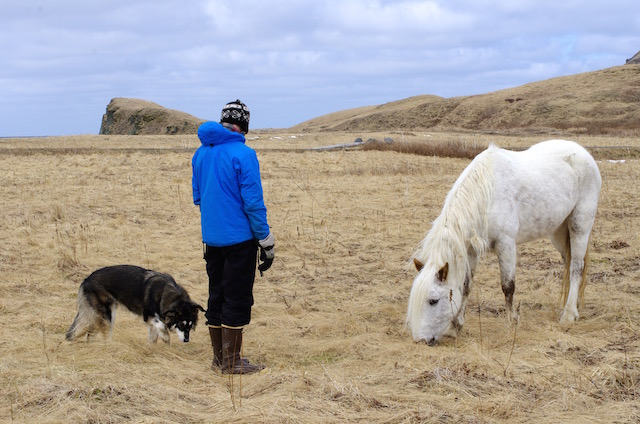

In [ ]:
from google.colab.patches import cv2_imshow
test_image = cv2.imread("data/person.jpg")
cv2_imshow(test_image)

## Train a Custom Model

### Create a backup directory for the weights

In [ ]:
%rm -r /content/darknet/backup

rm: cannot remove '/content/darknet/backup': No such file or directory


In [ ]:
%mkdir ../drive/MyDrive/custom_object/backup/

In [ ]:
!ln -s /content/drive/MyDrive/custom_object/backup/ /content/darknet/

### Train the model

Auxiliary parameters:

- **map** flag:  if set, it generates a raster plot/graph of the loss and mean average precision
- **dont_show** flag: if set, it prevents attempts to display the progress chart which may cause disruptions in the notebook environment


In [ ]:
!./darknet detector train custom_data/face_mask.data customization/yolov4.cfg customization/yolov4.conv.137 -map -dont_show

It timed out after  9h 17m 45s with approximately 95% of the iterations completed. We used the best weights obtained 

### While Training

 
- **progress chart**: there is an image file (PNG) generated periodically to report the latest mean average precision (mAP) vs the Loss value for each iteration. It can be found inside the darknet directory. You may download this to check the training progress.
- **log**: there may be times when it stalls, but that is temporary and the  process is running in the background
- **disconnection/timeout**: in this case, check your backup folder in Google Drive for which you created the symbolic link. You will find several weight files. Among them, there is one generated for every 1,000 iterations, one with the best weights computed (highest mAP and not  lowest Loss), and one with  the latest weights before timeout or training  completion. You may choose to reconnect the notebook and start from where you stopped by running the following:

In [ ]:
!./darknet detector train custom_data/face_mask.data customization/yolov4.cfg /content/drive/MyDrive/custom_object/backup/yolov4_last.weights -map -dont_show

/bin/bash: ./darknet: No such file or directory


### Upon Training Completion

Once training is complete, dowload the following:

1. best weights file, i.e., ```MyDrive/custom_object/backup/yolov4_best.weights```
2. the configuration file ```/content/darknet/customization/yolov4.cfg```
3. the  summary chart image file ```/content/darknet/chart_yolov4.png```


to deploy the custom yolov4 object dector, please see the next notebook, titled *object_detection_yolov4_custom_model_deploy.ipynb*